# CAS Final project - Document classification as images

### by Nicolas Gaillard (nicolas.gaillard@ba.admin.ch) and Frederic Bärtl (frederic.baertl@ba.admin.ch) 

### Date: 1st of August 2023

###
###
###
###


# 1. Introduction

## 1.1 Background 

The Office of the Attorney General (OAG) as a national law enforcement element is analyzing millions of unstructured documents every year. To facilitate this analysis, the OAG is using "key word" search software to identify potentially relevant documents. 

Our department (Forensic financial analysis - FFA) realised that this approach falls short to identify all relevant document as the quality of scanned documents is not ideal for an optical caracter recognition (OCR) based classification. Consequently, we see a substantial advantage in machine learning based classification of documents as a "pre-filter" or "pre-determination" step in our analytical work. 

## 1.2 Initial Idea 

At OAG we are dealing with a multitude of different categories of documents that require an analysis according to the actual task on the procedure. For example "transaction analytics" requires the analysis of bank documents while a "communication analysis" would require analyzing emails and chats. 

An effective automated classification would allow for a substantial reduction in documents to be read by our analysts and further help to identify documents that might stay hidden using an OCR approach. As the analysis of bank information is our primary work, we wanted to focus on the classification of such documents. To do so, we extracted documents from different ongoing cases and classified the documents as "bank information" or "other documents" as a simple binary classification task. In total we extracted approx. 100000 bank documents as well as 100000 other documents of various types extracted from different procedures.  Due to the confidential nature of those documents, we were restricted to work on OAG laptops. We installed JUPITER NOTEBOOK in order to perform the coding directing on those laptops. After multiple iterations with our IT we had to withdraw this idea as the OAG laptops where not able to run JUPITER NOTEBOOK in any shape or form due to the very strong security settings (we were unable to change).    

## 1.3 Adjustments needed / data used

As an alternative, we looked out for a comparable dataset to be used as a "blue print" that can be applied to OAG data at a later stage and found the RVL-CDIP dataset https://adamharley.com/rvl-cdip/, which is comparable to OAG data. Consequently, we shifted our focus to training this model and using the trained model on a small selection of "real" OAG documents that have been redacted and cleared for usage on non-OAG infrastructure. 

Our final report will therefore focus on the best possible training of the RVL-CDIP dataset and only a "sneak peak" into the application of OAG data. Consequently we see this report more like a "proof of concept" that such a classification task would work and what are the the crutial problems with regards to model accuracy and other technical limitations.   



# 2. Data preparation

## 2.1 Dataload

The images are stored in category specific folders and needed to be reorganised to reflect the separation of training, validation and test set. In addition, due to the size of the dataset we could not load the image information as performed in previous moduls. Futhermore we made use of dataframes for statistics while we used the tensorflow "ImageDataGenerator" functionality to prepare the images for model training. 



In [67]:
# Import the necessary libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
from PIL import Image

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define the dataset location 
#(remark: Frederic created an identical user on his computer to allow for the exact same jupiter notebook 
#to be used by Nicolas and himself at the same time )

dataset_path = '/Users/nicoga/Downloads/rvl-cdip/images/' # Adapt the path accordingly

In [3]:
# Create labelled folders --> Has been "deactived" to avoid creating the folders each time

classes = {'0': 'letter', '1': 'form', '2': 'email', '3': 'handwritten', '4': 'advertisement', 
           '5': 'scientific report', '6': 'scientific publication', '7': 'specification', 
          '8': 'file folder', '9': 'news article', '10': 'budget', '11': 'invoice', 
          '12': 'presentation', '13': 'questionnaire', '14': 'resume', '15': 'memo'}

rooth_path = '/Users/nicoga/Downloads/rvl-cdip/images/' 

#def make_doc_dirs(path):
   # for label in classes.values():
       # if not os.path.exists(path + str(label)):
           # os.mkdir(path + str(label))

# "real_data" stands for the redacted information extracted from the OAG cases (see X.X)

#make_doc_dirs('/Users/nicoga/Downloads/rvl-cdip/SortedData/Training/')
#make_doc_dirs('/Users/nicoga/Downloads/rvl-cdip/SortedData/Testing/')
#make_doc_dirs('/Users/nicoga/Downloads/rvl-cdip/SortedData/Validation/')
#make_doc_dirs('/Users/nicoga/Downloads/rvl-cdip/SortedData/real_data/')

In [5]:
# Sort the images in the corresponding folders to reflect the split into training, validation and test set

import shutil

def transfer_files_from_txt(txt_file_path, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)

    with open(txt_file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                file_path, class_name = line.split(' ')
                class_folder = os.path.join(destination_folder, class_name)
                os.makedirs(class_folder, exist_ok=True)

                source_file_path = os.path.join(os.path.dirname(txt_file_path), file_path)
                if os.path.exists(source_file_path):
                    shutil.copy2(source_file_path, class_folder)
                    print(f"Transferred file: {source_file_path} to {class_folder}")
                else:
                    print(f"File not found: {source_file_path}")

In [ ]:
# Training dataset 

txt_file_path = '/Users/nicoga/Downloads/rvl-cdip/images/train.txt'
destination_folder = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Training/'
transfer_files_from_txt(txt_file_path, destination_folder)

In [ ]:
# Sorting the images in the testing dataset 

txt_file_path = '/Users/nicoga/Downloads/rvl-cdip/images/test.txt'
destination_folder = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Testing/'
transfer_files_from_txt(txt_file_path, destination_folder)

In [ ]:
# Sorting the images in the validation dataset

txt_file_path = '/Users/nicoga/Downloads/rvl-cdip/images/val.txt'
destination_folder = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Validation/'
transfer_files_from_txt(txt_file_path, destination_folder)

In [ ]:
# Sorting the images in the real dataset has been done manually be allocating the images into the respective folder structure 

### 2.1.1 Observations 

When loading the data, we realised that we were not prepared to deal with data where the label information is actually stored in the folder structure rather than in a column of prepared CSV or already in a dataframe. Section 2.2 shows how we were dealing with this limitation. 

## 2.2 Exploratory Data Analysis

The RVL-CDIP is a dataset of approx. 400000 documents from 16 different document classes ranging from emails to handwritten notes.

To better understand the underlying documents we decided to visualise the class distribution of our images in each of the datasets (training, test, validation, real) as well as a combined view (excl. real). 

Furthermore, we calculated average dimensions as well as the "pixel distribution" information of the images to better understand how much individual information is actually stored per image, considering the "random pixels" of our images not to contribute. 

### 2.2.1. Analysis of images per class 

Creation of necessary variables for a "restructuring" of the data followed by the conversion of the dataset information into dataframes and a quick quantitative analysis per class

In [69]:
img_path_train = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Training/'
img_path_val = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Validation/'
img_path_test = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Testing/'
img_path_real = '/Users/nicoga/Downloads/rvl-cdip/SortedData/real_data/'
img_label = ['0','1','2','3','4', '5','6','7','8','9','10','11','12','13','14','15']
img_labelname = ['letter','form','email','handwritten','advertisement', 'scientific report','scientific publication','specification','file folder','news article','budget','invoice','presentation','questionnaire','resume','memo']

Creation of different data frames per dataset to facilitate the exploratory analysis (not needed for the model training) 

In [70]:
#Training datsaset
#Combine our data and labels in a dataframe to make data analysis easier (as this format was used in earlier modules)

import pandas as pd
import os
img_list2 = []
label_list2 = []
for label in img_label:
    for img_file in os.listdir(img_path_train+label):
        img_list2.append(img_path_train+label+'/'+img_file)
        label_list2.append(label)
        
df_train = pd.DataFrame({'img':img_list2, 'label':label_list2})

In [71]:
#Validation dataset
#Combine our data and labels in a dataframe to make data analysis easier (as this format was used in earlier modules)

import pandas as pd
import os
img_list = []
label_list = []
for label in img_label:
    for img_file in os.listdir(img_path_val+label):
        img_list.append(img_path_val+label+'/'+img_file)
        label_list.append(label)
        
df_val = pd.DataFrame({'img':img_list, 'label':label_list})

In [72]:
#Test dataset
#Combine our data and labels in a dataframe to make data analysis easier (as this format was used in earlier modules)

import pandas as pd
import os
img_list3 = []
label_list3 = []
for label in img_label:
    for img_file in os.listdir(img_path_test+label):
        img_list3.append(img_path_test+label+'/'+img_file)
        label_list3.append(label)
        
df_test = pd.DataFrame({'img':img_list3, 'label':label_list3})

In [73]:
#Real OAG dataset
#Combine our data and labels in a dataframe to make data analysis easier (as this format was used in earlier modules)

import pandas as pd
import os
img_list4 = []
label_list4 = []
for label in img_label:
    for img_file in os.listdir(img_path_real+label):
        img_list4.append(img_path_test+label+'/'+img_file)
        label_list4.append(label)
        
df_real = pd.DataFrame({'img':img_list4, 'label':label_list4})

In [74]:
#Combine the datsets into a single dataframe 
Combined= [df_train, df_test, df_val]
df_combined = pd.concat(Combined)

In [100]:
Allcounts= [df_train['label'].value_counts(), df_test['label'].value_counts(), df_val['label'].value_counts(), df_real['label'].value_counts()]
df_allcounts = pd.concat(Allcounts, axis =1)
df_allcounts.columns =['Training Set', 'Test Set', 'Validation Set', 'Real data' ]
df_allcounts.sort_index(axis= 0)
display(df_allcounts)

,Training Set,Test Set,Validation Set,Real data
0,20103,2464,2430,NaN
12,20043,2489,2468,NaN
13,20042,2435,2516,NaN
3,20031,2532,2434,NaN
8,20012,2527,2451,10.0
10,20010,2505,2485,23.0
14,20006,2536,2424,NaN
7,19997,2472,2531,8.0
9,19987,2463,2526,64.0
5,19984,2498,2508,NaN


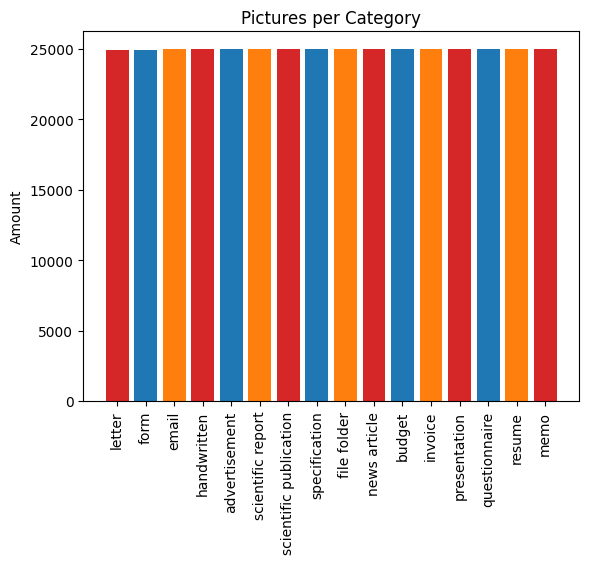

In [101]:
fig, ax2 = plt.subplots()
counts=df_combined.label.value_counts().sort_values()
bar2_labels = ['letter','form','email','handwritten','advertisement', 'scientific report','scientific publication','specification','file folder','news article','budget','invoice','presentation','questionnaire','resume','memo']
bar2_colors = ['tab:red', 'tab:blue', 'tab:orange','tab:red', 'tab:blue', 'tab:orange','tab:red', 'tab:blue', 'tab:orange','tab:red', 'tab:blue', 'tab:orange','tab:red', 'tab:blue', 'tab:orange','tab:red']

ax2.bar(bar2_labels, counts, label=bar2_labels, color=bar2_colors)

ax2.set_ylabel('Amount')
ax2.set_title('Pictures per Category')
#ax2.legend(title='Classes')
plt.xticks(rotation = 90)
plt.show()

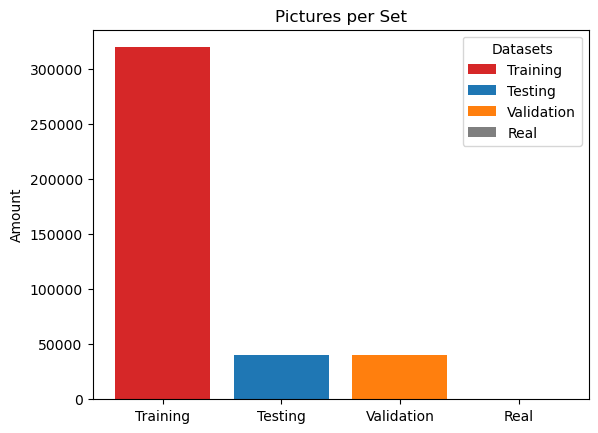

In [16]:
#Showing the image distribution per dataset (due to the same size of the real dataset, it appears as "zero")

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sets = ['Training', 'Testing', 'Validation','Real']
counts = [df_train.shape[0], df_test.shape[0], df_val.shape[0], df_real.shape[0]]
bar_labels = ['red', 'blue', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:grey']

ax.bar(sets, counts, label=sets, color=bar_colors)

ax.set_ylabel('Amount')
ax.set_title('Pictures per dataset')
ax.legend(title='Datasets')

plt.show()

#### Remark

As per previous modules, we worked with a a bigger training set approx. 320000 images compared to the the validation set of approx. 50000 images (approx 15 %)

The "real" dataset is relatively small, this is not intended but due to the current realities within OAG as all documents had to be manually redacted and approved by at least 2 people before we can extract the images. Nevertheless this should not pose any problems as we are not training the model on this data and will only make use of the "real dataset" in the last section to evaluate the performance of the model on the actual OAG data. 

When using the model for productive work within OAG we would require a different approach as substantial amounts of images have to be extracted as part of the actual model training (see section 4.3)

We believe that emails and news articles should be relatively easy for the model to apply on OAG data as they look very similar to the RVL-CDIP dataset. 


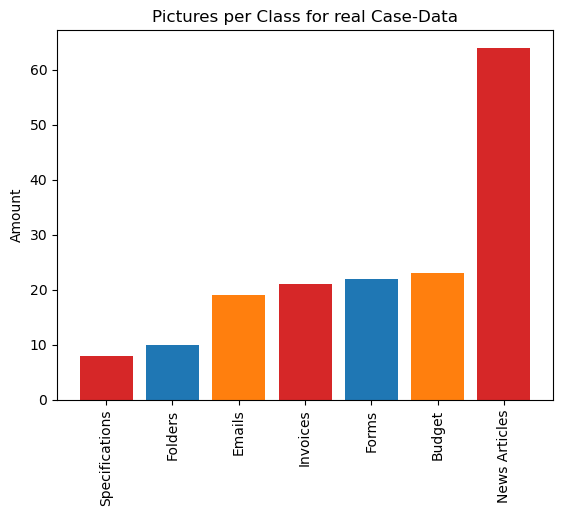

In [19]:
fig, ax3 = plt.subplots()
counts=df_real.label.value_counts().sort_values()
bar2_labels = ['Specifications','Folders','Emails','Invoices','Forms', 'Budget','News Articles']
bar2_colors = ['tab:red', 'tab:blue', 'tab:orange','tab:red', 'tab:blue', 'tab:orange','tab:red']

ax3.bar(bar2_labels, counts, label=bar2_labels, color=bar2_colors)

ax3.set_ylabel('Amount')
ax3.set_title('Pictures per Class for real Case-Data')
#ax2.legend(title='Classes')
plt.xticks(rotation = 90)
plt.show()

### 2.2.1. Analysis of images characteristics 

Visualisation of the images follow by a quick analysis of the image dimensions to make sure that the images are comparable after data resizing/normalisation. Furthermore, we look at the amount of information stored per image ("pixel distribution per image")  

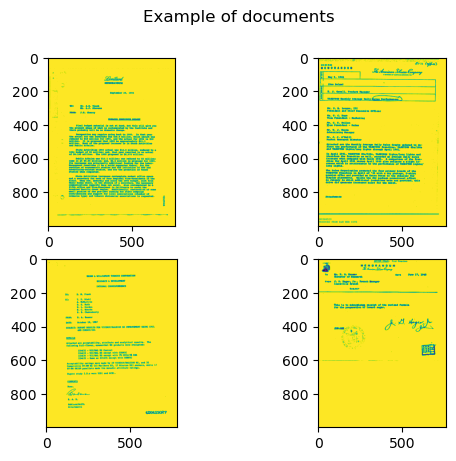

In [27]:
import matplotlib.pyplot as plt
fig, axr = plt.subplots(2,2)
fig.suptitle('Example of documents')
random_num = 16
axr[0,0].imshow(plt.imread(df_train[df_train['label']==label]['img'].iloc[random_num*2]))
axr[0,1].imshow(plt.imread(df_train[df_train['label']==label]['img'].iloc[random_num*3]))
axr[1,0].imshow(plt.imread(df_train[df_train['label']==label]['img'].iloc[random_num+2]))
axr[1,1].imshow(plt.imread(df_train[df_train['label']==label]['img'].iloc[random_num+20]))



In [148]:
# Get the maximum width

def get_max_image_width(folder_path):
    max_width = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    width = img.width
                    if width > max_width:
                        max_width = width
            except (IOError, OSError, Image.UnidentifiedImageError):
                pass

    return max_width

folder_path = '/Users/nicoga/Downloads/rvl-cdip/SortedData/'
max_width = get_max_image_width(folder_path)

print("Maximum image width:", max_width)

/Users/fredbert/opt/anaconda3/envs/Testfred/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Maximum image width: 3235


No image exceeds 3225 pixels which indicates some images are in a horizontal like format as the expected width should be around 750 pixel.  

In [149]:
# Get the maximum height

def get_max_image_height(folder_path):
    max_height = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    height = img.height
                    if height > max_height:
                        max_height = height
            except (IOError, OSError, Image.UnidentifiedImageError):
                pass

    return max_height

folder_path = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Training/'
max_height = get_max_image_height(folder_path)

print("Maximum image height:", max_height)

Maximum image height: 1000


All images show a maximum hight of 1000 pixels in line with the expected image resolution. 

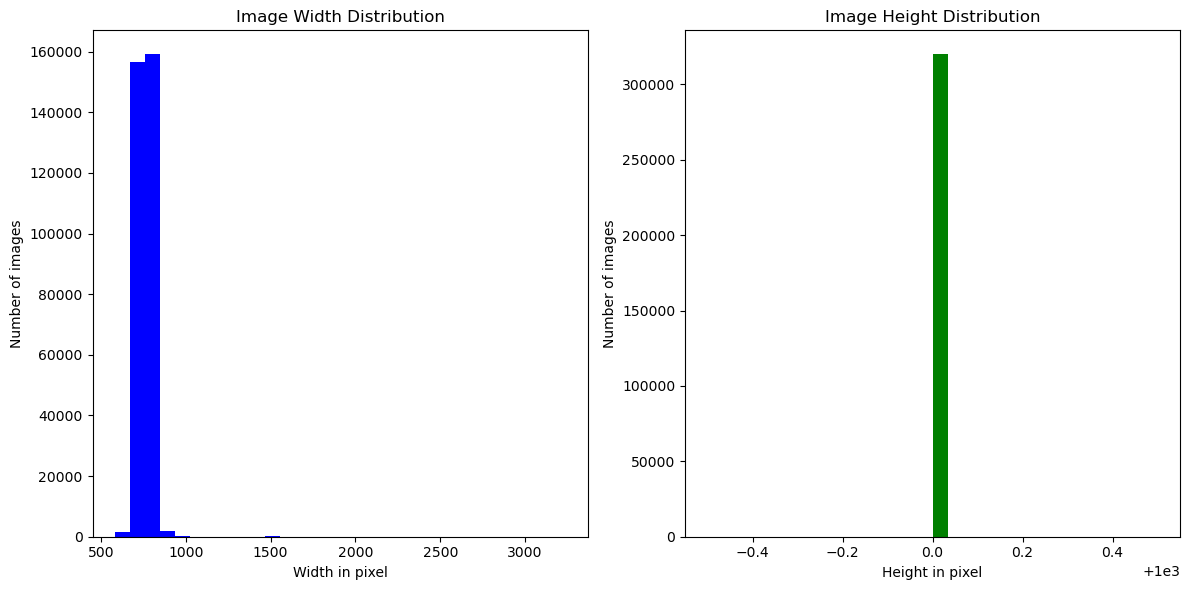

In [150]:
# Plotting the image dimensions

def get_image_dimensions(folder_path):
    widths = []
    heights = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except (IOError, OSError, Image.UnidentifiedImageError):
                pass

    return widths, heights

folder_path = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Training'
widths, heights = get_image_dimensions(folder_path)

# Plotting histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue')
plt.xlabel('Width in pixel')
plt.ylabel('Number of images')
plt.title('Image Width Distribution')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green')
plt.xlabel('Height in pixel')
plt.ylabel('Number of images')
plt.title('Image Height Distribution')

plt.tight_layout()
plt.show()

As we can see, the image dimensions are very similar and only a few images are much wider. Due too the small size of this sample, this can be ignored and we refused to exclude those "anormal" images from the datasets.

/Users/fredbert/opt/anaconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


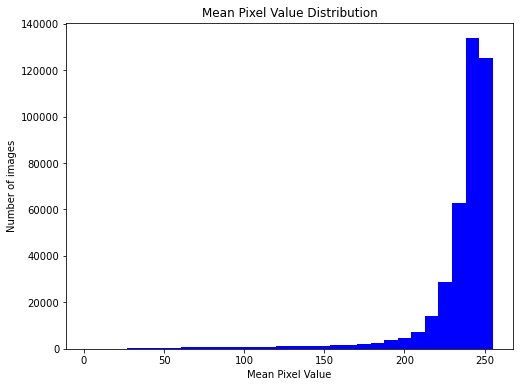

In [51]:
# Plotting the mean pixel value distribution

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def get_mean_pixel_values(folder_path):
    mean_pixel_values = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    pixels = np.array(img)
                    mean_pixel = np.mean(pixels)
                    mean_pixel_values.append(mean_pixel)
            except (IOError, OSError, Image.UnidentifiedImageError):
                pass

    return mean_pixel_values

folder_path = '/Users/nicoga/Downloads/rvl-cdip/SortedData/'
mean_pixel_values = get_mean_pixel_values(folder_path)

# Plotting histogram
plt.figure(figsize=(8, 6))
plt.hist(mean_pixel_values, bins=30, color='blue')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Number of images')
plt.title('Mean Pixel Value Distribution')

plt.show()

We can see that the that the mean pixel value > 200 meaning that we have suffient variation in pixel brightness on our images to actually distinguish them. Nevertheless, certain images have relatively low mean pixel values, making the categorisation more difficult (example a white folder might be hard to distinguish from a white sheet). 

# 3. Machine Learning Analysis - Model Training  

To achieve a maximum performance (accuracy, recall) of our machine learning model, we did not try to build a simple model ourselves (as already done in Module 6) but rather tried to apply the most performant "pre-trained" models available to us. We identified VGG-16 as well as ResNet for our purpose of image classification. 

VGG-16 has been chosen as the standard model to train the RVL-CDIP dataset while ResNet was named as the "next best" model for image classification. 

Before model training, we needed to prepare the data using the "datagen" functionality. In additional we saved the image and label information in separate variables for later result analysis. We further rescaled the images to 224x224 pixels.   

In [11]:
#Import of additional functionalities 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_dir = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Training/'
val_dir = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Validation/'
test_dir = '/Users/nicoga/Downloads/rvl-cdip/SortedData/Validation/'
real_dir= '/Users/nicoga/Downloads/rvl-cdip/SortedData/real_data/'

#Image rescaling: 
train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)
val_datagen = ImageDataGenerator(rescale=1/255.0)

# Load the training and validation data (as well as testing and real data)
train_data = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32, shuffle = False)
for X_train, Y_train in train_data:
    break

val_data = val_datagen.flow_from_directory(val_dir,
                                                target_size=(224, 224),
                                                batch_size=32, shuffle = False)
for X_val, Y_val in val_data:
    break

test_data = val_datagen.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                batch_size=32, shuffle = False)
for X_test, Y_test in test_data:
    break

real_data = val_datagen.flow_from_directory(real_dir,
                                                target_size=(224, 224),
                                                batch_size=32, shuffle = False)
for X_real, Y_real in real_data:
    break



Found 319837 images belonging to 16 classes.
Found 39995 images belonging to 16 classes.
Found 39995 images belonging to 16 classes.
Found 167 images belonging to 16 classes.


In [103]:
#QC check on the shape of the newly build variables 
print(Y_train.shape)
print(Y_test.shape)
print(Y_real.shape)
print(X_train.shape)
print(X_test.shape)
print(X_real.shape)

(32, 16)
(32, 16)
(32, 16)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)


## 3.1. Model training with VGG-16

By using the VGG-16 model, we are also benefiting from an increased accuracy due to "transfer learning" as this model has been pre-trained on more than 14 milliond images from 22000 different categories (ImageNet dataset). Thus our model does not need to start from scratch but can benefit from this "experience". (Info from: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/)

With Imagenet pretraining, we can theoretically expect an accuracy of approx. 90 percent. 
(https://paperswithcode.com/paper/cutting-the-error-by-half-investigation-of/review/?hl=2211)

Below the VGG16 model with the additional layers tailored to our 16 classes classification problem: 

In [3]:
#Adjustment of the VGG16 model to our problem 
from keras.optimizers import SGD

basel_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True 

final_model = Sequential()
final_model.add(base_model)
final_model.add(Flatten(input_shape=(224,224,3))) 
final_model.add(Flatten())
final_model.add(Dense(256, activation = 'relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(16, activation = 'sigmoid'))

#base_model.summary() - only used to check the structure of the "pre-fabricated" VGG16 model 
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
Total params: 21141584 (80.65 MB)
Trainable params: 2114

In [50]:
#COMPILING AND MODEL TRAINING

final_model.compile(optimizer =SGD(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'] )

#Done-VGG16.
        
hist=final_model.fit(train_data, validation_data=(test_data), steps_per_epoch = 25 ,batch_size = 32, epochs = 50, verbose = 1,) #callbacks [mcp_save,tbCallBack])
        
#Settings considered but not used for this specific model: 

# model.compile(loss = 'binary_crossentropy', optimizer = 'Adam',
    # Not used as Adam delivered much lower accuracy in the first 5 epochs (stopped afterwards)
          
#metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    #Alternative metrics not used as it requires complete retraining (min. 48h-60h of running time)  

        
        

Epoch 1/50
25/25 [==============================] - 5198s 216s/step - loss: 2.7733 - accuracy: 0.0675 - val_loss: 2.7727 - val_accuracy: 0.0627
Epoch 2/50
25/25 [==============================] - 5111s 212s/step - loss: 2.7725 - accuracy: 0.0725 - val_loss: 2.7727 - val_accuracy: 0.0627
Epoch 3/50
25/25 [==============================] - 5105s 212s/step - loss: 2.7723 - accuracy: 0.0675 - val_loss: 2.7727 - val_accuracy: 0.0627
Epoch 4/50
25/25 [==============================] - 5113s 212s/step - loss: 2.7729 - accuracy: 0.0550 - val_loss: 2.7727 - val_accuracy: 0.0627
Epoch 5/50
25/25 [==============================] - 5113s 212s/step - loss: 2.7731 - accuracy: 0.0512 - val_loss: 2.7727 - val_accuracy: 0.0627
Epoch 6/50
25/25 [==============================] - 5122s 213s/step - loss: 2.7722 - accuracy: 0.0675 - val_loss: 2.7727 - val_accuracy: 0.0627
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 2.7730 - accuracy: 0.0737 

KeyboardInterrupt: 

### Remarks

As you can see above the model training was not possible on the laptop of Frederic, even after multiple tries and different environment settings, the model always stopped after 5-7 epochs. Thus we needed to run the model (final_model) on Nicolas laptop and reimport the saved model weights here (see below), unfortunately the model can not be reimported as the joblib function is not compatible with the environment settings. Consequently, the complete development from epoch to epoch can not be displayed in this notebook and is provided in the second attached notebook (VGG-section3.1)


In [10]:
#VG16 Model import from Nicolas laptop 
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
import sklearn.externals as extjoblib
import joblib
import numpy as np
#import pickle

# load the model from disk
loaded_model = joblib.load('VGG16v1.sav')
#result = loaded_model.score(X_test, Y_test)
#print(result)

AttributeError: 'SGD' object has no attribute 'build'

### 3.1.1. Observations 

The VGG-16 model shows a training accuracy of approx. 60 percent with a validation accuracy of approx. 68%. This is not bad but still lower than expected. The validation accuracy is  on the same level indicating that the model might be able to add value when running on the test data as well as the real data. 

We initially wanted to train the model with more epochs to receive more conversion but had to limit ourselves as the 25 epoch model already required more than 4 days of pure machine time. (see lessons learned in section 4.3) 

The result for test_data and real data can be derived from the below stated confusion matrixes. 

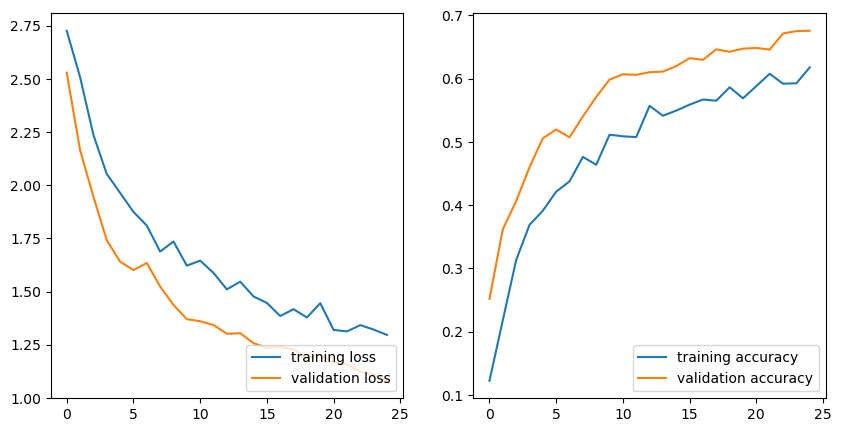

#### Remark

The loss and accuracy plots have been extracted from the Jupiter Notebook: "VGG-16-final.ipynd". This notebook further provides details regarding the VGG-16 Model.

#### Confusion Matrix for Test dataset

We can see that the valication accuracy is very low. This is very bizarre considering that the same dataset was used during model validation (test_data) (see final_model.fit)

We therefore believe that the below stated accuracy as well as the matrix itself are not valid. As discussed in the ResNet section (3.2), we tried several approaches to building the matrix but apparently failed due to the potentially flawed logic to extract the predicted labels. 
#### 
Validation accuracy: 6.143267908488561 %


In [ ]:
#Confusion Matrix for Test_data
[[150 169 159 159 167 164 159 162 182 154 159 177 178 160 181 165]
 [292 293 304 272 310 296 277 295 309 297 275 284 285 327 273 292]
 [117 119 125 111 136 128  99 134 125 112 119 128 113 127 125 110]
 [126 123 111 117 111 113 130 129 108 139 124 104 122 106 122 127]
 [199 202 203 203 176 206 202 208 193 184 216 201 211 205 182 201]
 [144 148 143 156 147 141 141 161 150 134 149 140 159 163 143 160]
 [157 146 145 146 140 134 138 145 159 151 148 149 153 143 166 136]
 [150 148 158 157 159 130 147 136 125 131 169 151 127 138 158 165]
 [155 162 149 164 153 164 157 140 145 154 166 153 181 149 132 161]
 [128 165 148 154 142 164 143 147 160 145 144 151 162 146 154 169]
 [167 174 174 188 174 158 178 197 164 179 187 178 164 150 169 185]
 [ 94 102  84 114  66 110 108  96 115  90  96 104  81 112  94  84]
 [137 165 152 149 136 146 126 146 148 148 144 151 158 149 143 148]
 [114 101 114 138 140 142 141 132 137 107 129 105 131 140 103 103]
 [162 192 170 197 175 173 150 152 165 167 168 176 165 183 151 169]
 [138 128 146 151 136 147 128 153 145 142 129 156 134 133 155 151]]

#### Confusion Matrix for Real dataset

We can see that the valication accuracy is very low. And provides completely different predictions when compared to the ResNet results (see 3.2)
# 
Accuracy of real OAG data: 10.179640718562874 %

In [ ]:
#Confusion Matrix for Real data
[[4 1 2 0 2 1 2 6 0 0 0 0 0 0]
 [3 5 2 0 3 2 0 8 0 0 0 0 0 0]
 [3 0 2 0 2 0 1 2 0 0 0 0 0 0] 
 [3 5 3 0 3 1 2 6 0 0 0 0 0 0]
 [2 0 4 0 1 1 1 8 0 0 0 0 0 0]
 [1 1 3 0 2 2 0 7 0 0 0 0 0 0]
 [2 4 0 0 4 0 2 6 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 3 0 0 1 0 0 5 0 0 0 0 0 0]
 [2 0 1 0 1 0 1 8 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 3 3 0 0 0 1 3 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 0 0]]

#### Remark

Overall, the performance of the model itself is good but we fail to transfer the predictions from the model into a coherent confusion matrix to better understand which classes are predicted and which are not. As long as this problem is not solved, we can not improve the model (e.g. with selective image augmentation) and we can not make conclusions which classes to "trust" for a potential productive application in the future. 

## 3.2. Model training with ResNet

When looking at the relatively mediocre performance of the VGG-16 model, we wanted to understand if we have better results using another pre-trained model. Aaain we are benefiting from an increased accuracy due to "transfer learning" as this model has been pre-trained on more than 14 milliond images from 22000 different categories (ImageNet dataset). According to multiple papers, we can expect a more or less equal performance, compared to the VGG-16 model.

We followed the same logic, using the ResNet50 "base model" and adding layers to reflect our dataset structure with 16 classes. 

In [13]:
#Same images trained using ResNet50 (Remark: Provides lower accuracy with near random val_accuracy)
from tensorflow.keras.applications import ResNet50
Conv_Base = ResNet50(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))

model4 = Sequential()
model4.add(Conv_Base)
model4.add(Flatten())
model4.add(Dense(units = 256, activation = 'relu'))
model4.add(Dropout(0.5))
model4.add(Dense(16, activation = 'sigmoid'))
model4.summary()

model4.compile(loss = 'categorical_crossentropy',
            optimizer = 'Adam',
            metrics = ['accuracy'])#tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

histRES=model4.fit(train_data, validation_data=(test_data), steps_per_epoch = 50 ,batch_size = 64, epochs = 25, verbose = 1,)
              


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
Total params: 49,282,192
Trainable params: 49,229,072
Non-trainable params: 53,120
_________________________________________________________________


In [7]:
#model4.metrics_names (only needed to check as the metrics sometimes ends up having numbers at the end of each word)

['loss', 'accuracy']

In [52]:
# Save the weights
model4.save_weights('ResNet50.hdf5')

# Load the weights
#model.load_weights('my_model_weights.hdf5')

###### 3.2.1. Observations

The ResNet Model shows a training accuracy of approx. 50 percent, which is not to bad considering 16 classes but far below the approx. 90% according to other papers: https://paperswithcode.com/paper/cutting-the-error-by-half-investigation-of/review/?hl=2211 

When looking at the validation images, we can see that the accuracy varies substantially, with a very confusing reaction between the epochs 20 and 24. (See table 1 below)

Thus our trust in the results of the ResNet model is low. We believed that re-training the model with 50 epochs might "smooth out" those peaks and result in a more stable validation accuracy (and a further increasing training accuracy). Unfortunately, the re-training failed multiple times due to a lack of computational power (running time > 100 hours on our macbooks). 

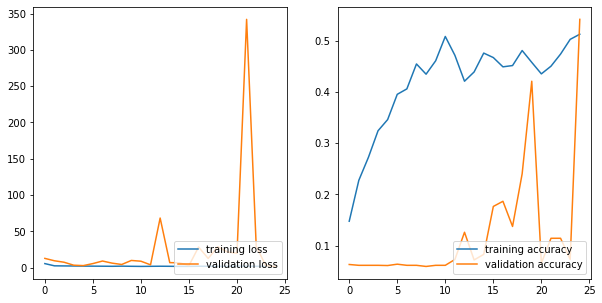

In [8]:
#Table 1 - Loss and Accuracy for the ResNet Model with 25 epochs 
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(histRES.epoch, histRES.history['loss'])
axs[0].plot(histRES.epoch, histRES.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(histRES.epoch, histRES.history['accuracy'])
axs[1].plot(histRES.epoch, histRES.history['val_accuracy'])
axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

We saved the model to make sure we can use the model weights for training on different datasets in the future (not going to happen with this model due to the low performance), unfortunately the reimport function of joblib is not working in our environments. 

In [9]:
#ResNet Model has been stored for further analysis without retraining the model. 

import joblib
# save the model to disk
#filename = 'ResNet50.sav'
#joblib.dump(model4, filename)

# load the model from disk
#loaded_model = joblib.load(filename)
#result = loaded_model.score(X_test, Y_test)
#print(result)

['ResNet50.sav']

### Remark

As the model has already "seen" training data as well as validation data (test_data) , we ran the model on the unseen "val_data" to evaluate the performance. We received an non-convincing accuracy of 6.25 % which is quasi random. (see below). We do no understand how this is possible as the model training showed a final test accuracy of approx. 50 percent und an equal value has been expected for the confusion matrix. 

We understand that the accuracy of the confusion matrix is calculated based on the true predictions divided by all images thus we believe that the representation of the confusion matrix must be wrong even though we changed multiple papers all showing an identical approach to building the matrix. 



In [15]:
from sklearn.metrics import confusion_matrix

In [58]:
#CONFUSION MATRIX FOR  TEST SET (as "Test data")

# Predictions
pred8 = model4.predict_generator(test_data)
predicted8 = np.argmax(pred,axis=1)

# Actual Labels
labels8 = val_data.classes

# Compute Accuracy
conf_mat = confusion_matrix(predicted8, labels8)
cm = conf_mat
acc8 = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
print('Validation accuracy - ResNet Model: {} %'.format(acc8*100))
print(conf_mat)

/var/folders/gy/twp2p7k96gqfdvr9cl2lmbrh0000gn/T/ipykernel_78696/2860970766.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred8 = model4.predict_generator(test_data)
2023-08-01 22:45:05.861716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation accuracy - ResNet Model: 5.250656332041506 %
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 248  194  142  245  185  220  186  201   33  238  421  145  766  179
   441  518]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  26   86  105  125  239   70   26   50    2   82 1172   76   88   67
   189  218]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  48   97   62  161   46  104    8   43    4  230  325   50   51  106
    98  119]
 [   5   10    2    5    8    5    2    9    1   28    7    5   17    5
     7   20]
 [   0   

### Remark

When applying the model to "unseen data" we can see that the accuracy is even worst (approx. 5.25 %) and the matrix is not showing any useful predictions. (see above)

When checking our small real data sample, we see a relatively mediorce accuracy of approx. 32% for the real data. When analysing a bit more, we see that there is clear biais in the model trying to allocate most of the real images into the category 9 ("news articles"), on the other hand out of the 64 real news paper articles, 53 have been allocated correctly, meaning that this class is the only one where we could apply the model for image classification within OAG.  

/var/folders/gy/twp2p7k96gqfdvr9cl2lmbrh0000gn/T/ipykernel_78696/814413585.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred4 = model4.predict_generator(real_data)
2023-08-01 21:21:15.689991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation accuracy: 32.33532934131736 %
Confusion matrix, without normalization
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 5  1  0  0  0  0  0  0  1  4]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [16 22 21  0 18  0  0  7  9 53]]


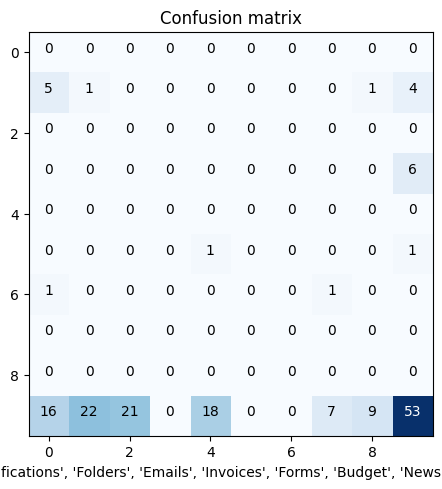

In [53]:
## CONFUSION MATRIX FOR REAL DATA SET 

# Predictions
pred4 = model4.predict_generator(real_data)
predicted4 = np.argmax(pred4,axis=1)

# Actual Labels
labels4 = real_data.classes
labels_real = ['1','2','7', '8','9','10', '11']
labels_real_names = ['1. Formulare','2. Emails','7. Specifications', '8. Folders','9. News Articles','10. Budgets', '11. Invoices']
# Compute Accuracy
conf_mat4 = confusion_matrix(predicted4, labels4)
cm = conf_mat4
acc4 = np.sum(conf_mat4.diagonal()) / np.sum(conf_mat4)
print('Validation accuracy: {} %'.format(acc4*100))
#print(conf_mat4)

#labels = ['memo','resume','questionnaire','presentation','invoice', 'budget','news article','file folder','specification','scientific publication','scientific report','advertisement','handwritten','email','form','letter']

import itertools

def plot_confusion_matrix(cm, classes1, labels = '9',
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  #plt.colorbar()
  #tick_marks = np.arange(len(classes1))
  #plt.xticks(tick_marks, classes1, rotation=45) #classes1
  #plt.yticks(tick_marks, classes1, rotation=45)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.xlabel(['Specifications','Folders','Emails','Invoices','Forms', 'Budget','News Articles'])
  #plt.ylabel(['11. Invoices','10. Budgets', '9. News Articles', '8. Folders',  '7. Specifications','2. Emails', '1. Formulare'])
  plt.show()

plot_confusion_matrix(cm, list(range(10)))

### Remark

When reviewing the confusion matrix for the validation dataset we received a matrix that looks much more heterogeneous than the test data matrix above. We have no explanation for such a different behaviour and believe that the underlying logic to calculate the predictioned labels (using argmax) must be flawed for our case. 

Confusion matrix, without normalization
[[216 239 223 237 232 229 192 218 240 248 226 204 244 234 236 212]
 [ 88  75  76  84  87  87  84  81  98  70 106  73  96  86  89  77]
 [134 130 127 134 165 122 125 133 120 111 125 127 129 126 118 133]
 [114 121 143 131 118 134 135 122 120 126 132 126 144 132 116 119]
 [292 299 273 306 262 250 246 266 263 259 290 256 263 261 257 290]
 [ 83  89  83  96  66 106  97  87  80  95  94  89  99  92 102 106]
 [150 150 158 148 148 155 158 145 183 138 133 159 150 150 131 149]
 [ 80  60  71  74  59  70  82  67  77  69  81  72  75  82  68  83]
 [169 167 162 169 178 189 172 184 168 161 157 190 160 201 184 164]
 [233 256 288 250 261 290 299 272 273 259 264 273 257 263 291 265]
 [271 281 267 281 288 262 251 285 306 276 288 291 283 279 267 287]
 [107 109 122 131 108 103  98 113 104 106 110 133 126 115 114 122]
 [102 105  88 110 100 108  91 102 101 104 109 105 103 102  96 113]
 [141 176 170 165 144 147 160 187 158 149 154 179 144 159 155 152]
 [165 173 145 146 162 

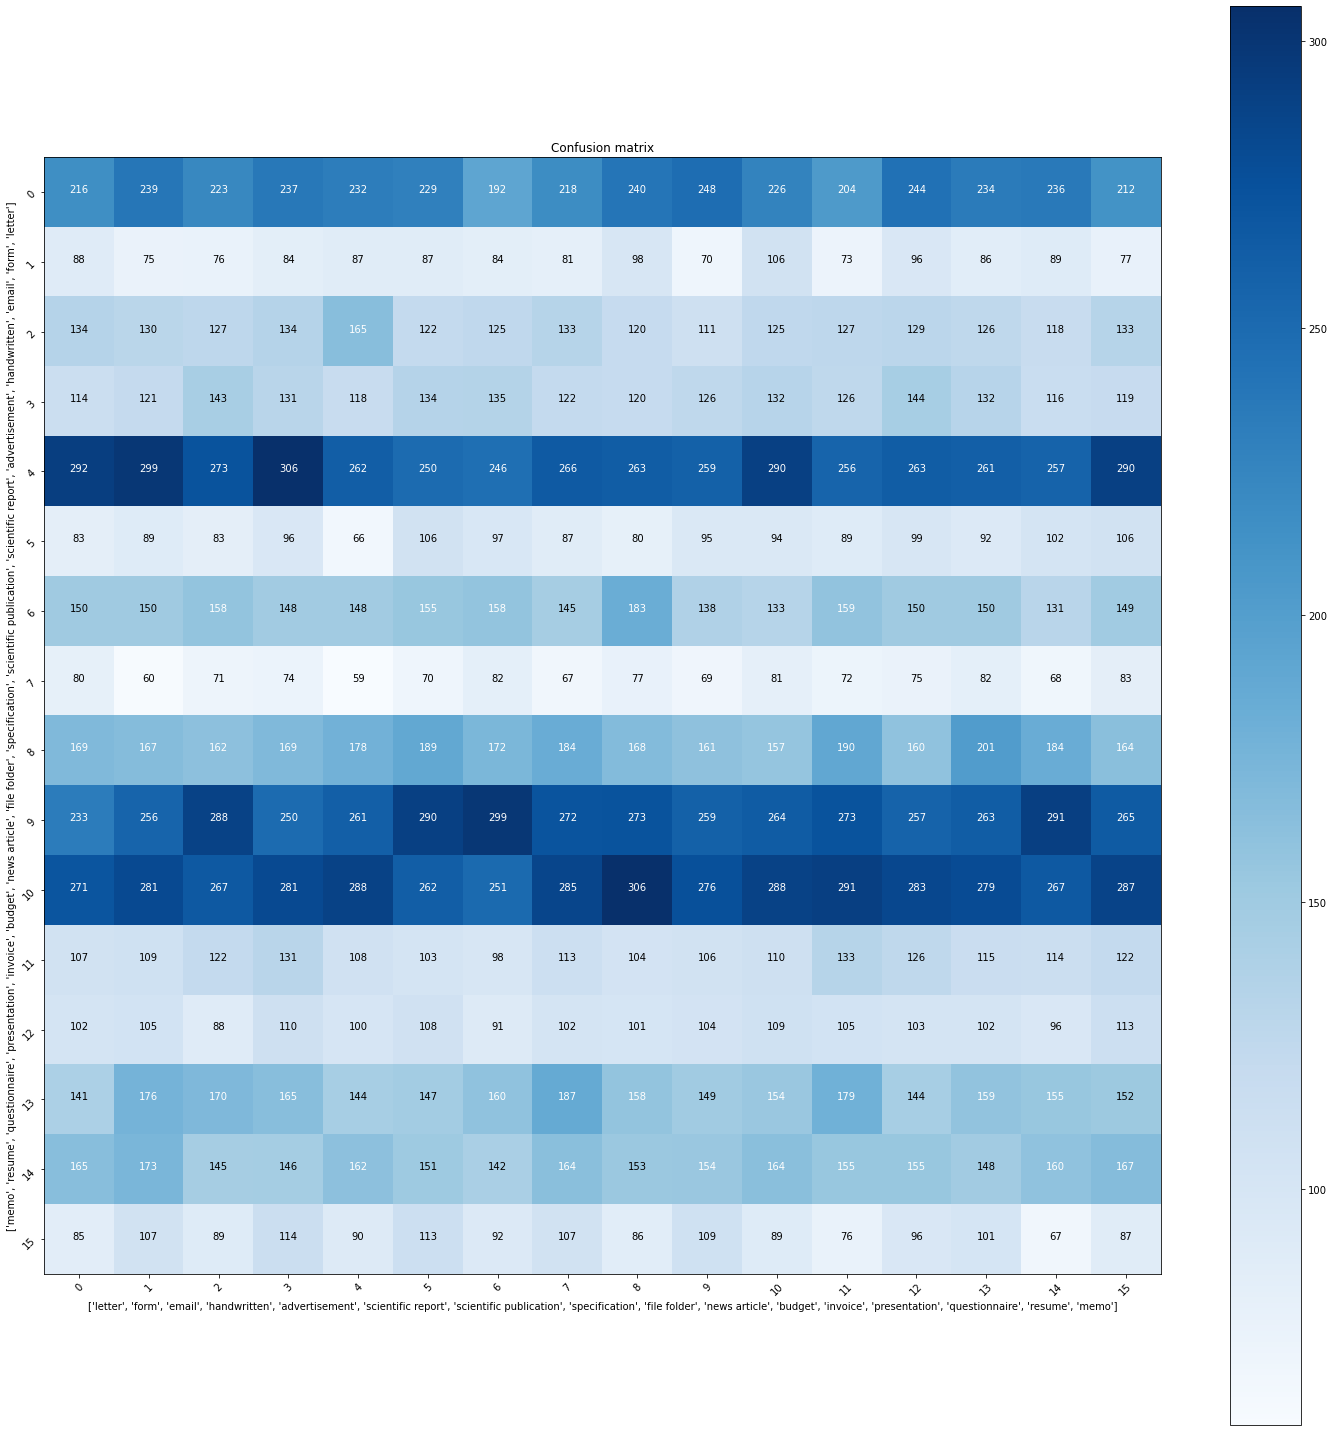

In [47]:
#CONFUSION MATRIX FOR  VALIDATION SET !!! (run before using the "cm" variable above)

# Predictions
pred6 = model4.predict_generator(real_data)
predicted6 = np.argmax(pred4,axis=1)

# Actual Labels
labels6 = real_data.classes
labels_real = ['1','2','7', '8','9','10', '11']
labels_real_names = ['1. Formulare','2. Emails','7. Specifications', '8. Folders','9. News Articles','10. Budgets', '11. Invoices']
# Compute Accuracy
conf_mat6 = confusion_matrix(predicted6, labels6)
cm = conf_mat6
acc6 = np.sum(conf_mat4.diagonal()) / np.sum(conf_mat6)
#print('Validation accuracy: {} %'.format(acc6*100))
#print(conf_mat4)

#labels = ['memo','resume','questionnaire','presentation','invoice', 'budget','news article','file folder','specification','scientific publication','scientific report','advertisement','handwritten','email','form','letter']


classes1 = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'}

import itertools
plt.rcParams['figure.figsize'] = [20,20]

def plot_confusion_matrix(cm, classes1,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes1))
  plt.xticks(tick_marks, classes1, rotation=45)
  plt.yticks(tick_marks, classes1, rotation=45)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel(['memo','resume','questionnaire','presentation','invoice', 'budget','news article','file folder','specification','scientific publication','scientific report','advertisement','handwritten','email','form','letter'])
  plt.xlabel(['letter','form','email','handwritten','advertisement', 'scientific report','scientific publication','specification','file folder','news article','budget','invoice','presentation','questionnaire','resume','memo'])
  plt.show()

plot_confusion_matrix(cm, list(range(16)))

# 4 Results discussion 

## 4.1 Overall performance 

We can derive from our analysis that the VGG-16 model as such provides better results. We are still far away from the "promised" model accuracy of approx. 80 percent. Thus the model in this form is not sufficiently good to be used on "real data" but might be used in addition to "highlight" additional documents that require manual review.

In addition, we do not believe that the confusion matrixes are reflecting the correct classifications and would require further analysis to understand the underlying reason. Multiple alternative approaches to constructing the matrixes have been tried without success. 


## 4.2 Required improvements for "productive usage"

a) We need to better understand why our model is not providing equal performance as other pre-trained CNNs on the exact same datasets. Our main assumption is that an increase of epochs will result in higher accuracy as we still see an increasing trend and not yet perfect conversion.  

b) We would need to replace a portion of the RVL-CLIP images in each class with OAG data to make sure the model is trained on data that has to be expected during productive work. This can be semi-automated as can rely on pre-classified data from older cases as well as document format based classification from our search term based analysis software ("Nuix"). Nevertheless this requires having a working jypiter notebook within the OAG IT infrastructure. 

c) We would aim to decrease the amount of classes to focus on the classes that are relevant for our work at OAG (namely: emails, presentations, invoices, budget/accouting docs and handwritten text). On the other hand we will add at least one additional class (transactional bank information), this would be the easiest as we have multiple tousand of such images already prepared. From the initial idea (see section 1.2) 

d) We have to consider resizing the images to a format that is more similar to our OAG information. Unfortunately this would mean increasing resolution which means increasing the machine time needed to re-train the model. This would not be possible on our macbooks and would again require having a dedicated infrastructure within OAG

e) Image splitting has been proposed to increase model accuracy from 80 to 90 percent, thus such a method would have to be implemented on top of the existing model. Again, this is currently not possible considering the limited performance of our macbooks. 


## 4.3 Lessons learned for further classification projects

a) When training on consumer level laptops due to (security) restrictions, it would be beneficial to reduce the size of the training dataset and trade a little bit of model performance against a substantial performance increase. This approach has been used by the "DocFormer" paper (see references). Due to the massive size of the dataset and the machine time involved we did not dare to reduce the file size per image to see how the performance changes and followed the widely picked resolution of 224 x 224 pixels. 

b) It is substantially easier to work with information that is already stored in one document with multiple (2) columns like a csv or a dataframe rather than building a labeling logic by ourselves and understanding how to extract the label information from the "combined" file that is created with the help of the "image generator" functionality. 

c) Running jupiter notebook on Macs comes with additional problems regarding GPU support. We were unable to active GPU support during model training. THus for future adjustments we will use windows computers with a dedicated graphics card. The very easy to follow instructions below did unfortunately not work on the macbooks: https://saturncloud.io/blog/how-to-run-jupyter-notebook-on-gpus/ 

d) When using multiple laptops it is crucial to use the exact same environment settings, otherwise data transfer via pickle/joblib is extremely difficult and coding might react different / showing an error when run on the other laptop. For this reason Ananconda alows to backup the environment and then use this as import for the other laptop (when we realised to late in the process). 

## 4.4 Self assessment

We understand that the outcome of our project is sobering. At the same time we believe that we much better understand the crucial milestones when implementing this approach within OAG. We understand that certain requirements (see 4.2) have to be clarified and studied further before we can make use of such an VGG bases classification model but we are looking forward to such an implementation once the infrastructure within OAG has been provided.

We would be very grateful if you could provide us with an adjusted logic for the confusion matrixes (in case you identify the problem) as this is is essential for further model optimisations. 

## References

Image classification wit RVL CDIP: (incl. image splitting)
https://arxiv.org/pdf/1704.03557.pdf
https://www.kaggle.com/code/iamsouravbanerjee/image-classification-decoded-case-study/notebook

Other image classification articles/notebooks: 
https://medium.com/mlearning-ai/image-classification-for-beginner-a6de7a69bc78
https://github.com/fbaertl/Applied_Data_science_CAS_2022/blob/main/Module3/CAS_M3_Un_Supervised_ML.ipynb

Image classification - benchmark results:
https://paperswithcode.com/paper/cutting-the-error-by-half-investigation-of/review/?hl=2211
https://pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/

Manipulation of RVL CDIP:
https://www.kaggle.com/code/akarshu121/document-image-classification-with-docformer/notebook
https://wandb.ai/iakarshu/RVL%20CDIP%20with%20DocFormer%20New%20Version/reports/Performance-of-DocFormer-with-RVL-CDIP-Test-Dataset--VmlldzoyMTI3NTM4

Model saving and loading
https://towardsdatascience.com/how-to-reuse-your-python-models-without-retraining-them-39cd685659a5
https://stackoverflow.com/questions/47266383/save-and-load-weights-in-keras
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
https://stackoverflow.com/questions/34864695/saving-prediction-results-to-csv

Further support on confusion matrixes
https://www.jcchouinard.com/confusion-matrix-in-scikit-learn/
https://datascience.stackexchange.com/questions/95009/good-model-but-bad-confusion-matrix
https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
https://stackoverflow.com/questions/63753111/vgg16-net-validation-accuracy
https://stackoverflow.com/questions/68608978/how-to-create-a-confusion-matrix-for-vgg16-image-calssification-2-options-when

Information on GPU use for Mac
https://towardsdatascience.com/accelerated-tensorflow-model-training-on-intel-mac-gpus-aa6ee691f894

Support for package installer
https://www.activestate.com/resources/quick-reads/how-to-install-keras-and-tensorflow/
https://stackoverflow.com/questions/72331431/how-to-solve-no-module-named-keras-saving-pickle-utils-error
